##  Polarization Density: Water embedded in Water using sDFT/MBX

In [2]:
import os
import numpy as np
import glob
from ase.io import read, write
from ase.io.xsf import read_xsf, write_xsf
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [3]:
class IniFileWriter:
    def __init__(self, data: dict, filename=None):
        self.data = data
        self.filename = filename

    def write_edftpy(self):
        if self.filename is None:
            self.filename="mbx.ini"
        with open(self.filename, 'w') as f:
            for section, values in self.data.items():
                f.write(f"[{section}]\n")
                for key, value in values.items():
                    f.write(f"{key:<16} = {value}\n")
                f.write("\n")
                
    def write_qe(self):
        if self.filename is None:
            self.filename="qe_in.in"
        with open(self.filename, 'w') as f:
            for section_name, section_data in self.data.items():
                f.write(f"&{section_name}\n")
                for key, value in section_data.items():
                    f.write(f"   {key:<16} = {value}\n")
                f.write("/\n\n")

In [4]:
folder = './Polarization_density/QMMM'
folder_qm = './Polarization_density/QMQM'

### 1. Entire System

### 1.1 Set-up eDFTPy Input File

In [5]:
system_1 = '/all/'

In [6]:
config_data = {
    "JOB": {
        "task": "Optdensity"
    },
    "PATH": {
        "pp": "../../",
        "cell": "./"
    },
    "PP": {
        "O": "o_pbe_v1.2.uspp.F.UPF",
        "H": "h_pbe_v1.4.uspp.F.UPF"
    },
    "OPT": {
        "maxiter": 50,
        "econv": "1e-10",
        "olevel": 2,
        "sdft" : "qmmm"
    },
    "GSYSTEM": {
        "cell-file": "Bulk_0_0.xyz",
        "grid-ecut": 2700,
        "exc-xc": "pbe"
    },
    "SUB_KS": {
        "calculator": "pwscf",
        "embed": "KE XC",
        "kpoints-grid": "1 1 1",
        "basefile": "qe_in.in",
        "cell-index": "0:3",
        "nprocs": 1,
        "density-output": ".xsf"
    },
    "SUB_MM": {
        "calculator": "mbx",
        "embed": "KE",
        "kpoints-grid": "1 1 1",
        "basefile": "mbx.json",
        "cell-index":  "3:", 
        "nprocs" : 1,
        "density-output": ".xsf"
    }
}

In [7]:
writer = IniFileWriter(config_data, filename = folder+system_1+'mbx.ini')
writer.write_edftpy()

### 1.2 Set-up QE Input File

In [8]:
qe_data = {
    "SYSTEM": {
        "ecutwfc": 70,
        "ecutrho": 400,
        "nosym": "T"
    },
}

In [9]:
writer = IniFileWriter(qe_data, filename = folder+system_1+'qe_in.in')
writer.write_qe()

### 1.3 Run Density Optimization

In [11]:
job_dir = os.path.dirname(folder + system_1)
filename = "jobfile.sh"
filename_out = "runlog.out"
if os.path.exists(folder + system_1 + filename_out):
    None
else:
    os.system(f"cd {job_dir} && sbatch {filename} > {filename_out} 2>&1 &")

### 2. Environment 

The electronic density coming from the classical permanent charges and polarizable dipole sites is captured directly in the first calculation.

### 3. Run Single Water

Here the QM water is the same calculation done in QMQM Jupyter Notebook. 

## 4 Get Polarization Density

In [26]:
den_a_emb = './' + glob.glob(folder + system_1 + '*qm_1.xsf')[0][len(folder):]
den_b_emb = './' +glob.glob(folder + system_1 + '*mm_2.xsf')[0][len(folder):]

system_3 = '/swater/'
den_a_iso = '../../' + folder_qm[2:] +glob.glob(folder_qm + system_3 + '*qm_1.xsf')[0][len(folder):]
den_b_iso =  './' +glob.glob(folder + system_1 + 'dp_mm0.xsf')[0][len(folder):]

In [10]:
density_a_out = "pol_den_a.xsf"
density_b_out = "pol_den_b.xsf"
filename_a_out = "pol_log_a.out"
filename_b_out = "pol_log_b.out"

In [28]:
os.system(f"cd {folder} && python -m edftpy --convert --subtract {den_a_emb} {den_a_iso} -o {density_a_out} > {filename_a_out} 2>&1 &")

0

In [29]:
os.system(f"cd {folder}&& python -m edftpy --convert --subtract {den_b_emb} {den_b_iso} -o {density_b_out} > {filename_b_out} 2>&1 &")

0

# Visualization


#### 1. Plot a 3D Density

In [11]:
from ase.visualize import view

In [12]:
atoms = read(folder+'/'+density_a_out, format="xsf")
view(atoms, viewer='x3d')

In [13]:
density_a = []
with open(folder+'/'+density_a_out,"r") as f:
    density_a.append(read_xsf(f,read_data=True)[0])

In [14]:
density_b = []
with open(folder+'/'+density_b_out,"r") as f:
    density_b.append(read_xsf(f,read_data=True)[0])

#### Plot a 2D slice (middle along z-axis)

In [15]:
data = density_a[0]
# data = density_b[0]
nz = data.shape[2] 

origin = atoms.get_cell().origin if hasattr(atoms.get_cell(), "origin") else np.zeros(3)
ngrid = data.shape 
frac_coords = atoms.get_scaled_positions()
grid_indices = (frac_coords * ngrid).astype(int)

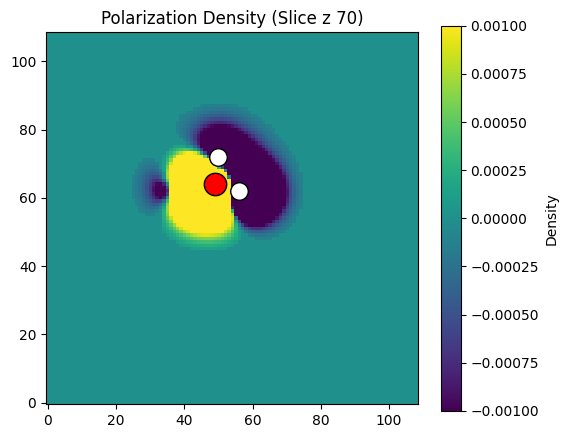

interactive(children=(IntSlider(value=70, description='index', max=108, min=35, step=5), Dropdown(description=…

In [16]:
@interact(
    index=IntSlider(min=35, max=nz-1, step=5, value=70),
    axis=['z', 'y', 'x']
)

def plot_slice(index=nz//2, axis=['z','y','x']):
    plt.figure(figsize=(6, 5))
    
    if axis == 'z':
        slice_data = data[:, :, index]
        atom_x, atom_y = grid_indices[:, 0], grid_indices[:, 1]
    elif axis == 'y':
        slice_data = data[:, index, :]
        atom_x, atom_y = grid_indices[:, 0], grid_indices[:, 2]
    else:  # axis == 'x'
        slice_data = data[index, :, :]
        atom_x, atom_y = grid_indices[:, 1], grid_indices[:, 2]
        
    threshold = 1e-4
    filtered_data = slice_data.copy()
    filtered_data[np.abs(filtered_data) < threshold] = 0 
   
    im = plt.imshow(filtered_data, origin='lower', cmap='viridis', vmin=-0.001, vmax=0.001)
    plt.colorbar(im, label='Density')
    plt.scatter(atom_y[0],atom_x[0], color='red', s=260, edgecolor='black')
    plt.scatter(atom_y[1],atom_x[1], color='white', s=160, edgecolor='black')
    plt.scatter(atom_y[2],atom_x[2], color='white', s=160, edgecolor='black')
    plt.title(f"Polarization Density (Slice {axis} {index})")
    plt.show()